# Pythagoras via Matrix

In [16]:
%matplotlib inline
import math
import random
import operator
import warnings
import numpy as np

from geneticprogramming import Baseset
from geneticprogramming import Individual
from geneticprogramming import Population

warnings.filterwarnings("ignore")

## Training data 

* a number of random matrices (2D floating points) on a plane

In [2]:
SAMPLE_SIZE = 50
PLANE_SIZE = 20.0
RANDOMPOINTS = [PLANE_SIZE * np.random.random_sample((1, 2)) for _ in range(SAMPLE_SIZE)]

## Base functions

* _get_ a value at a location from a matrix
* an _ephemeral integer_ - either 0 or 1
* _addition_ and _subtraction_ of floats
* _square_ and _square root_ of floats

In [3]:
def getValue(ndarray, idx):
    """Return the indexed value from the 1x2 numpy array"""
    return ndarray[0][idx]

square = lambda x: x ** 2
sqrt = lambda x: math.sqrt(abs(x))

bset = Baseset()
bset.add_ephemeral('P', lambda: random.randint(0, 1), int)
bset.add_primitive(getValue, [np.ndarray, int], float, name="get")
bset.add_primitive(operator.add, [float, float], float, name="add")
bset.add_primitive(operator.sub, [float, float], float, name="sub")
bset.add_primitive(square, [float], float, name="square")
bset.add_primitive(sqrt, [float], float, name="sqrt")

## Individuals
* consume a matrix (a 1x2 array of floats - x and y coordinates)
* return a float (the distance from the origin)
* scored by accumulating the error when applying the Training data

In [4]:
Individual.INTYPES = [np.ndarray]
Individual.OUTTYPE = float

def evaluate(individual):
    """sum of application of all the random points"""
    program = individual.compile()
    score = 0
    try:
        for point in RANDOMPOINTS:
            program_distance = program(point)
            true_distance = math.hypot(point[0][0], point[0][1])
            score += abs(true_distance - program_distance)
    except (OverflowError, RuntimeWarning):
        pass
    if math.isnan(score) or score == 0:
        score = float('inf')
    return score,
Individual.evaluate = evaluate

## Population Evolution

In [17]:
NUM_GENERATIONS = 5

population = Population(bset)
for generation in range(NUM_GENERATIONS):
    population.evolve()

gen	avg	std	min    	max
0  	inf	nan	156.269	inf
1  	591.891	1178.18	156.269	6055.52
2  	251.193	244.386	156.269	2567.29
3  	212.557	45.3794	156.269	472.13 
4  	198.303	46.5067	156.269	472.13 


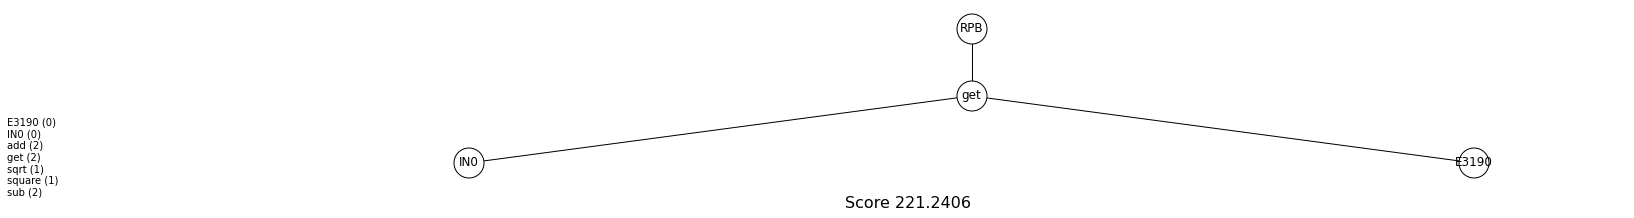

In [21]:
best = population[0]
best.draw()